# Read data and create timeseries using PICES LME

Look at SST, ocean currents, chl-a

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sys

global ds_pices360
sys.path.append('./subroutines/')
import pices

adir_data = './data/'

# Read in PICES mask

- Each dataset finds a unique and different way to define lat / lon or order them.
- There is a need for standardization in this area
- The basic PICES mask is -180 to 180 lon and -90 to 90 lat
- Below different maps are created for 0 to 360 lon
- Then each of the two different lon maps are also copied to reverse lat, 90 to -90

In [3]:
ds_pices360 = pices.get_mask()

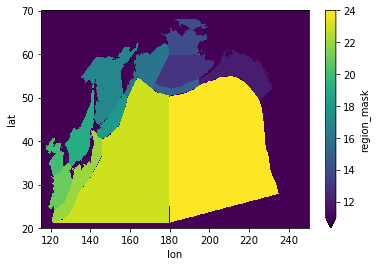

In [4]:
ds_pices360.sel(lon=slice(115,250),lat=slice(20,70)).region_mask.plot(vmin=11,vmax=24)

(array([ 21130.,  17355.,  15366.,  11188.,   4023.,  11715.,  21365.,
          6144.,  10643.,   4422.,   7316.,  12566., 108525., 140022.,
             0.,      0.]),
 array([10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5,
        21.5, 22.5, 23.5, 24.5, 25.5, 26.5]),
 <a list of 16 Patch objects>)

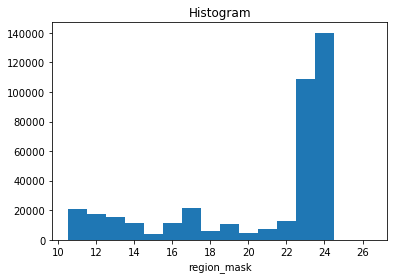

In [5]:
ds_pices360.region_mask.plot.hist(bins=np.arange(10.5,27))

# don't run this
- create local files

In [6]:
#ds.to_netcdf(file)
file = pices.get_filename('sst')
ds=xr.open_dataset(file)
ds.close()
#ds=ds.sortby(ds.lat,ascending=True)
#ds = ds.drop('time_bnds')
#ds.to_netcdf(file)
ds_sst = ds

#wind
file = pices.get_filename('wind')
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdlasFnWind10'
ds = xr.open_dataset(aggr_url).rename({'latitude':'lat','longitude':'lon'}).drop({'taux_mean','tauy_mean','curl'})
ds.to_netcdf(file)


## Read in SST data

In [ ]:
mn,clim,anom = pices.get_data('sst',13,'1992-01-01','2019-08-01')

In [ ]:
anom.sst.plot()

# stop here

In [ ]:
import pandas as pd
import xarray as xr
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplOscar'
ds = xr.open_dataset(aggr_url).isel(depth=0).rename({'latitude':'lat','longitude':'lon'}).drop({'um','vm'})
#date1 = pd.Series(pd.date_range('2019-09-01', periods=3*24, freq='H'))
date1 = pd.Series(pd.period_range('1992-10-01', periods=27*12, freq='M'))
init=0
for d in date1:
    dstr=str(d.year)+'-'+str(d.month).zfill(2)
    dstr2=str(d.year)+'-'+str(d.month).zfill(2)+'-01'
    ds2=ds.sel(time=slice(dstr,dstr)).sel(lon=slice(20.0,379.9))
    ds2 = ds2.assign_coords(lon=(((ds2.lon + 180) % 360) - 180)).sortby('lon').sortby('lat',ascending=True)
    ds3 = ds2.interp(lat=ds_sst.lat,lon=ds_sst.lon,method='linear').mean('time',keep_attrs=True)
    ds3=ds3.assign_coords(time=np.datetime64(dstr2))
    if init==0:
        ts=ds3
    else:
        ts=xr.concat((ts,ds3),dim='time')
        init=init+1
        break
ts.to_netcdf('cur_mean.nc')    

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [94]:
np.datetime64(dstr2)

numpy.datetime64('1993-01-01')

In [ ]:
file = pices.get_filename('sst')

ds = xr.open_dataset(file)
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)

#interpolate mask
mask_interp = ds_pices360_revlat.interp_like(ds,method='nearest')


#create sst mean for pices region
for iregion in range(11,25):
    cond = (mask_interp.region_mask==iregion)
    tem = weighted_mean_of_data(ds.sst,cond)
    tem=tem.assign_coords(region=iregion)
    if iregion==11:
        sst_mean=tem
    else:
        sst_mean = xr.concat([sst_mean, tem], dim='region')

#make climatology and anomalies using .groupby method
sst_climatology = sst_mean.groupby('time.month').mean('time')
sst_anomalies = sst_mean.groupby('time.month') - sst_climatology

sst_mean.to_netcdf(adir_data+'sst_mean.nc')
sst_climatology.to_netcdf(adir_data+'sst_climatology.nc')
sst_anomalies.to_netcdf(adir_data+'sst_anomalies.nc')

## Read in wind data

In [8]:

file

'./data/wind.mnmean.nc'

lat range 80.0 -80.0
lon range 20.0 420.0


In [60]:
print(ds.lon-360)



<xarray.DataArray 'lon' (lon: 1201)>
array([-340.      , -339.666667, -339.333333, ...,   59.333333,   59.666667,
         60.      ])
Coordinates:
    depth    float32 15.0
  * lon      (lon) float64 20.0 20.33 20.67 21.0 ... 419.0 419.3 419.7 420.0

In [23]:
ds3

<xarray.DataArray 'u' (lat: 481, lon: 1201)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time     datetime64[ns] 1992-10-21
    depth    float32 15.0
  * lat      (lat) float64 80.0 79.67 79.33 79.0 ... -79.0 -79.33 -79.67 -80.0
  * lon      (lon) float64 0.0 0.3333 0.6667 1.0 ... 358.7 359.0 359.3 359.7
Attributes:
    ioos_category:  Currents
    long_name:      Ocean Surface Zonal Currents
    units:          meter/sec

In [ ]:
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdlasFnWind10'
ds = xr.open_dataset(aggr_url).rename({'latitude':'lat','longitude':'lon'}).drop({'taux_mean','tauy_mean','curl'})
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)

#interpolate mask
mask_interp = ds_pices360.interp_like(ds,method='nearest')

for iregion in range(11,25):
    cond = (mask_interp.region_mask==iregion)
    tem = weighted_mean_of_data(ds,cond)
    tem=tem.assign_coords(region=iregion)
    if iregion==11:
        wnd_mean=tem
    else:
        wnd_mean = xr.concat([wnd_mean, tem], dim='region')

#make climatology and anomalies using .groupby method
wnd_climatology = wnd_mean.groupby('time.month').mean('time')
wnd_anomalies = wnd_mean.groupby('time.month') - wnd_climatology

wnd_mean.to_netcdf(adir_data+'wnd_mean.nc')
wnd_climatology.to_netcdf(adir_data+'wnd_climatology.nc')
wnd_anomalies.to_netcdf(adir_data+'wnd_anomalies.nc')

## Read in Ocean current data

In [ ]:
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplOscar'
ds = xr.open_dataset(aggr_url).isel(depth=0).rename({'latitude':'lat','longitude':'lon'}).drop({'um','vm'})
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)

#subset
ds = ds.sel(lon=slice(115,250),lat=slice(70,20))

#interpolate mask
mask_interp = ds_pices360_revlat.interp_like(ds,method='nearest')

for iregion in range(11,25):
    cond = (mask_interp.region_mask==iregion)
    tem = weighted_mean_of_data(ds,cond)
    tem=tem.assign_coords(region=iregion)
    if iregion==11:
        cur_mean=tem
    else:
        cur_mean = xr.concat([cur_mean, tem], dim='region')

#make climatology and anomalies using .groupby method
cur_climatology = cur_mean.groupby('time.month').mean('time')
cur_anomalies = cur_mean.groupby('time.month') - cur_climatology

cur_mean.to_netcdf(adir_data+'cur_mean.nc')
cur_climatology.to_netcdf(adir_data+'cur_climatology.nc')
cur_anomalies.to_netcdf(adir_data+'cur_anomalies.nc')

## Read in chl-a data

- The chl-a data is on a 4km grid, too high resolution to deal unless running on the cloud.
- For now, it is subsetted and interpolated onto a 1 deg grid

In [ ]:
aggr_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI31OceanColorMonthly'
ds = xr.open_dataset(aggr_url).rename({'latitude':'lat','longitude':'lon'})
print('lat range',ds.lat[0].data,ds.lat[-1].data)
print('lon range',ds.lon[0].data,ds.lon[-1].data)

#subset
#ds = ds.sel(lon=slice(115,250),lat=slice(70,20))
dsA = ds.chlor_a.sel(lon=slice(-180,-110),lat=slice(70,20))
dsB = ds.chlor_a.sel(lon=slice(115,180),lat=slice(70,20))


m=[]
for imon in range(0,250,5):
    ds2 = dsA.isel(time=slice(imon,imon+5))
    ds3 = ds2.interp(lat=np.arange(20,70),lon=np.arange(-180,-110))
    if imon==0:
        m=ds3
    else:
        m = xr.concat([m,ds3],dim='time')
dsA = m  

m=[]
for imon in range(0,250,5):
    ds2 = dsB.isel(time=slice(imon,imon+5))
    ds3 = ds2.interp(lat=np.arange(20,70),lon=np.arange(115,180))
    if imon==0:
        m=ds3
    else:
        m = xr.concat([m,ds3],dim='time')
dsB = m  
ds = xr.concat([dsA,dsB],dim='lon')
ds.coords['lon'] = np.mod(ds['lon'], 360)
ds = ds.sortby(ds.lon)
#create  mean for pices region
iregion=13
mask_interp = ds_pices360.interp_like(ds,method='nearest')
cond = (mask_interp.region_mask==iregion)
chl_mean = weighted_mean_of_data(ds,cond)

#make climatology and anomalies using .groupby method
chl_climatology = chl_mean.groupby('time.month').mean('time')
chl_anomalies = chl_mean.groupby('time.month') - chl_climatology

chl_mean.to_netcdf(adir_data+'chl_mean.nc')
chl_climatology.to_netcdf(adir_data+'chl_climatology.nc')
chl_anomalies.to_netcdf(adir_data+'chl_anomalies.nc')

## Testing still